# ASHW 04

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew
from sklearn.mixture import GaussianMixture
from tqdm import tqdm
from scipy.signal import find_peaks

## 1. zadatak

In [22]:
mase_cr = np.load("bhm.npy").flatten()
np.random.seed(42)
masses = np.random.choice(mase_cr, size=10000, replace=True)
std_dev = np.std(masses, ddof=1)
median = np.median(masses)
skewness = skew(masses)
print(std_dev)
print(median)
print(skewness)

7.066748485349409
26.51785933476059
-0.18289579090912955


In [24]:
#bootstrap
#nasumicno biranje podataka iz originalne grupe sa vracanjem
n_boot=10000
boot_samples=np.random.choice(masses,size=(n_boot,len(masses)), replace=True)

boot_std=np.std(boot_samples,axis=1,ddof=1)
boot_median = np.median(boot_samples, axis=1)
boot_skew = np.array([skew(sample) for sample in boot_samples])

boot_std_err = np.std(boot_std)
boot_median_err = np.std(boot_median)
boot_skew_err = np.std(boot_skew)

#jackknife
#slicno kao bootstrap ali se sad izostavi neki podatak
#prilagodjena iz stackoverflow
def jackknife(data,func,K=10000):
    n = len(data)
    rng = np.random.default_rng(0)
    estimates = np.zeros(K)

    np.random.seed(42)  # 42 je odgovor na sve
    
    for i in range(K):
        # Nasumično biramo dva različita indeksa
        indices_to_remove = np.random.choice(n, size=2, replace=False)
        
        mask = np.ones(n, dtype=bool) #maska bez ta dva 
        mask[indices_to_remove] = False
        estimates[i] = func(data[mask])

    mean_estimate = np.mean(estimates)
    std_error = np.std(estimates)

    return mean_estimate, std_error,estimates

jk_std_mean, jk_std_err, jk_std_raw = jackknife(masses, lambda x: np.std(x, ddof=1))
jk_median_mean, jk_median_err, jk_median_raw = jackknife(masses, np.median)
jk_skew_mean, jk_skew_err, jk_skew_raw = jackknife(masses, skew)

In [26]:
from tabulate import tabulate

data = [
    ["asimetrija", skewness,boot_skew_err,jk_skew_err ],
    ["medijana", median, boot_median_err, jk_skew_err],
    ["standardna devijacija", std_dev,boot_std_err,jk_std_err],
]
headers = ["statistika", "vrednost","bootstrap","jackknife"]

table = tabulate(data, headers=headers, tablefmt="grid")
print(table)

+-----------------------+------------+-------------+-------------+
| statistika            |   vrednost |   bootstrap |   jackknife |
+=======================+============+=============+=============+
| asimetrija            |  -0.182896 |   0.0234156 | 0.000334939 |
+-----------------------+------------+-------------+-------------+
| medijana              |  26.5179   |   0.119159  | 0.000334939 |
+-----------------------+------------+-------------+-------------+
| standardna devijacija |   7.06675  |   0.0464629 | 0.000682105 |
+-----------------------+------------+-------------+-------------+


In [28]:
#dodavanje 10 ekstremnih vrednosti
masses_ex = np.concatenate([masses, np.ones(10)*10000])
std_ex = np.std(masses_ex,ddof=1)
median_ex = np.median(masses_ex)
skew_ex = skew(masses_ex)

data = [
    ["original", std_dev,median,skewness ],
    ["extra vrednosti", std_ex, median_ex, skew_ex],
]
headers = ['statistics', "std deviation","median","skewness"]

table = tabulate(data, headers=headers, tablefmt="grid")
print(table)

+-----------------+-----------------+----------+------------+
| statistics      |   std deviation |   median |   skewness |
+=================+=================+==========+============+
| original        |         7.06675 |  26.5179 |  -0.182896 |
+-----------------+-----------------+----------+------------+
| extra vrednosti |       315.183   |  26.5243 |  31.5673   |
+-----------------+-----------------+----------+------------+


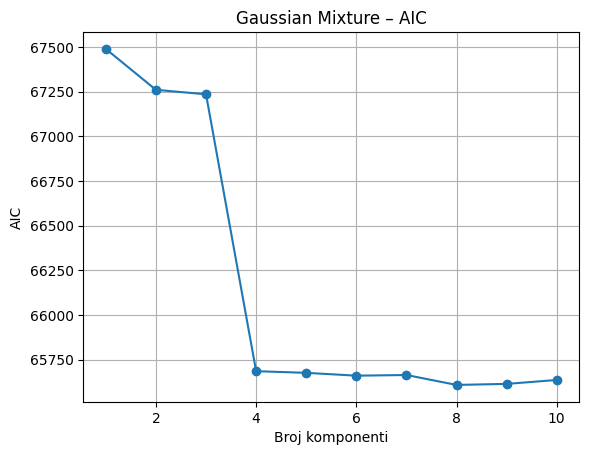

In [42]:
#hocu da plotujem peakove za najbolji broj komponenti
X = masses.reshape(-1, 1)
aics = []
n_components_range = range(1, 11)
models = []

for n in n_components_range:
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(X)
    aics.append(gmm.aic(X))
    models.append(gmm)

index = np.argmin(aics)+1 #jer je 7. u skupu od 1,11 zapravo 7+1 jer pocinje od 1


plt.figure()
plt.plot(n_components_range, aics, marker='o')
plt.xlabel("Broj komponenti")
plt.ylabel("AIC")
plt.title("Gaussian Mixture – AIC")
plt.grid(True)
plt.show()

+--------+-------------+-----------+
|   peak |   masa [M☉] |   Gustina |
+========+=============+===========+
|      1 |       14.31 |    0.0111 |
+--------+-------------+-----------+
|      2 |       20.23 |    0.0942 |
+--------+-------------+-----------+
|      3 |       25.36 |    0.0427 |
+--------+-------------+-----------+
|      4 |       28.66 |    0.0542 |
+--------+-------------+-----------+
|      5 |       31.75 |    0.0595 |
+--------+-------------+-----------+


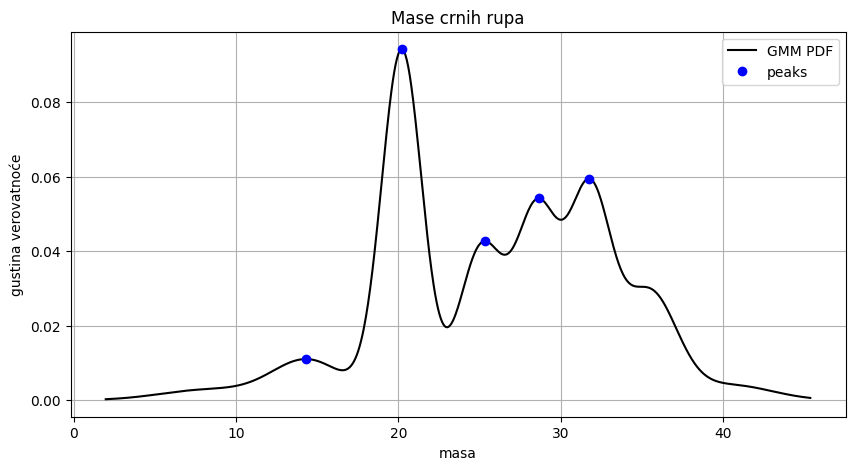

In [44]:
x_vals = np.linspace(min(masses), max(masses), 1000)
pdf = np.zeros_like(x_vals)

gmm = GaussianMixture(n_components=index, random_state=42)
gmm.fit(masses.reshape(-1, 1))

for w, mu, sigma in zip(gmm.weights_, gmm.means_.flatten(), np.sqrt(gmm.covariances_).flatten()):
    #funkcija normalne raspodele:
    comp_pdf = w * (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-(x_vals - mu)**2 / (2 * sigma**2))
    pdf += comp_pdf

peaks= find_peaks(pdf, height=0)[0]

table = []
for i, idx in enumerate(peaks):
    masa = x_vals[idx]
    gustina = pdf[idx]
    table.append([i + 1, f"{masa:.2f}", f"{gustina:.4f}"])

headers = ["peak", "masa [M☉]", "Gustina"]
print(tabulate(table, headers=headers, tablefmt="grid"))

plt.figure(figsize=(10, 5))
plt.plot(x_vals, pdf, label='GMM PDF', color='black')
plt.plot(x_vals[peaks], pdf[peaks], "bo", label="peaks")
plt.xlabel(r"masa")
plt.ylabel("gustina verovatnoće")
plt.title("Mase crnih rupa")
plt.legend()
plt.grid(True)
plt.show()

najbolji broj:  {8}


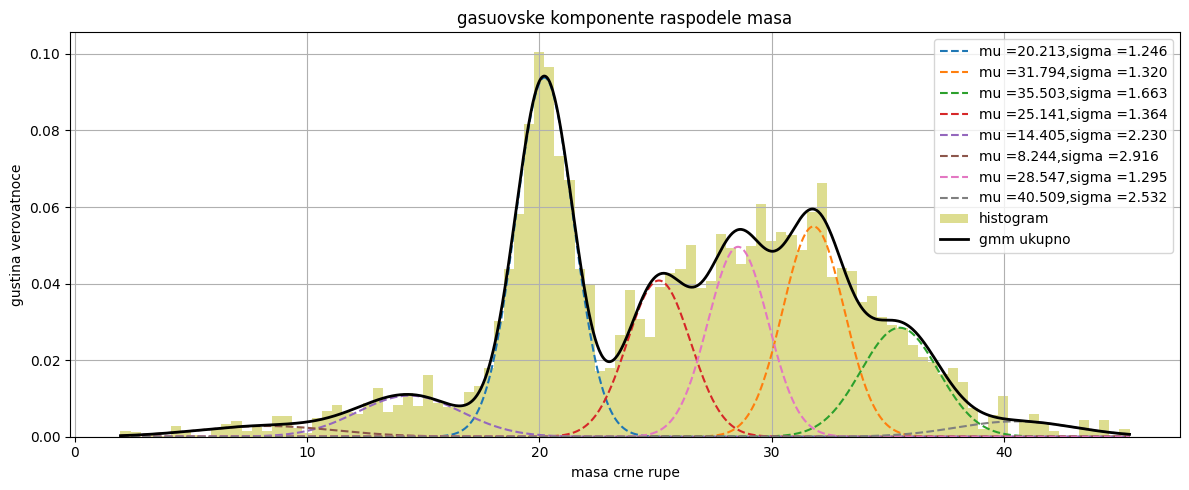

In [69]:
best_index = np.argmin(aics)
best_model = models[best_index]
print("najbolji broj: ",{n_components_range[best_index]})

x_vred = np.linspace(min(masses),max(masses),1000)
pdf = np.zeros_like(x_vred)

plt.figure(figsize=(12,5))
for w,mu,sigma in zip(best_model.weights_,best_model.means_.flatten(),(np.sqrt(best_model.covariances_).flatten())):
    comp_pdf = w*(1/(np.sqrt(2*np.pi)*sigma))*np.exp(-(x_vred-mu)**2 /(2*sigma**2))
    pdf +=comp_pdf
    plt.plot(x_vred,comp_pdf,linestyle="--", label=f"mu ={mu:.3f},sigma ={sigma:.3f}")

plt.hist(masses,bins=100,density=True, alpha =0.5, label="histogram")
plt.plot(x_vred, pdf, color="black",linewidth=2,label="gmm ukupno")
plt.title('gasuovske komponente raspodele masa')
plt.xlabel('masa crne rupe')
plt.ylabel('gustina verovatnoce')
plt.tight_layout()
plt.legend()
plt.grid()
plt.show()

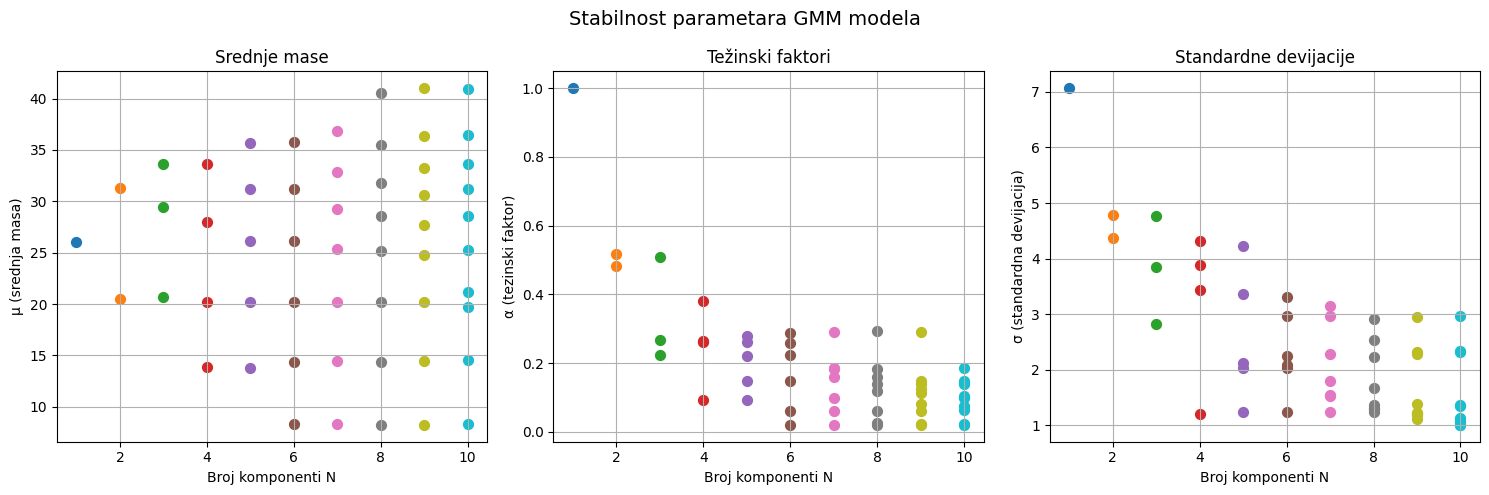

In [81]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)

# mu—srednje mase
for n, model in zip(n_components_range, models):
    mus = model.means_.flatten()
    axes[0].scatter([n]*len(mus), mus, s=50)
axes[0].set_xlabel("Broj komponenti N")
axes[0].set_ylabel("μ (srednja masa)")
axes[0].set_title("Srednje mase")
axes[0].grid(True)

# weights—težinski faktori
for n, model in zip(n_components_range, models):
    alphas = model.weights_.flatten()
    axes[1].scatter([n]*len(alphas), alphas, s=50)
axes[1].set_xlabel("Broj komponenti N")
axes[1].set_ylabel("α (tezinski faktor)")
axes[1].set_title("Težinski faktori")
axes[1].grid(True)

# sigma— standardne devijacije
for n, model in zip(n_components_range, models):
    sigmas = np.sqrt(model.covariances_).flatten()
    axes[2].scatter([n]*len(sigmas), sigmas, s=50)
axes[2].set_xlabel("Broj komponenti N")
axes[2].set_ylabel("σ (standardna devijacija)")
axes[2].set_title("Standardne devijacije")
axes[2].grid(True)

plt.suptitle("Stabilnost parametara GMM modela", fontsize=14)
plt.tight_layout()
#plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Učitano: 2950 masa. Raspon: 1.9651 - 45.398 (M⊙)

Osnovne statistike (original):
  n: 2950
  mean: 26.10465080907568
  std: 7.13807612694856
  median: 26.644318451484118
  skewness: -0.2140876401607866

Bootstrap: 10000 reuzorkovanja ...
  Gotovo za 9.3 s. SE (std, median, skew) = [0.08744111 0.19955455 0.0414308 ]

Jackknife (leave-two-out) ...
  Pairs used: 20000 (used_all_pairs=False). Vrijeme: 16.5s.
  Jackknife SE (std, median, skew) = [0.32638782 0.54488804 0.15232629]


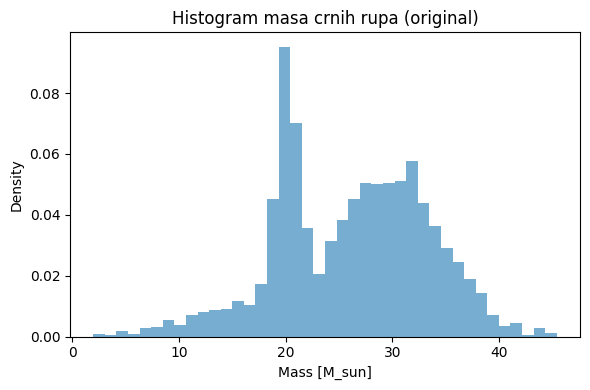

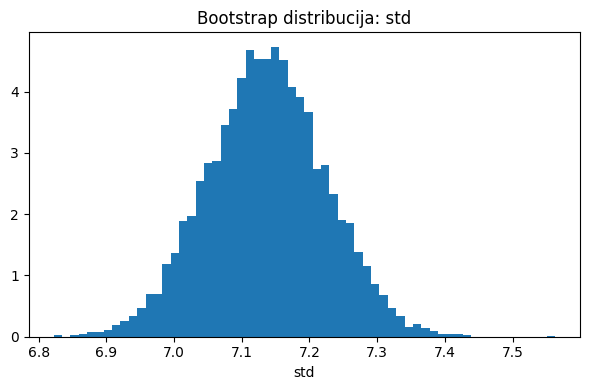

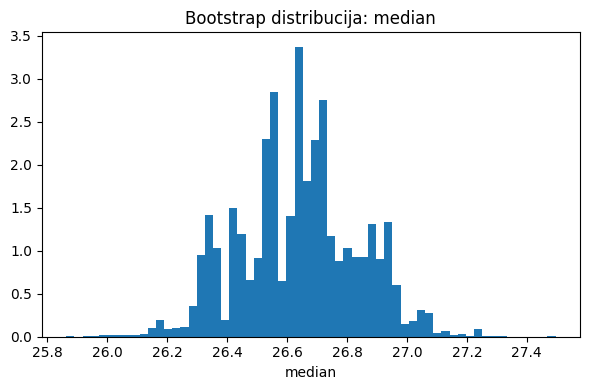

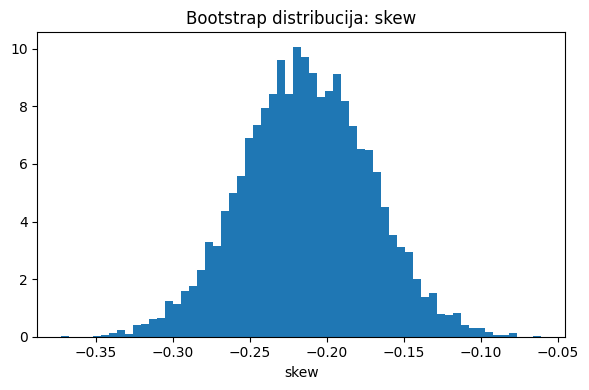

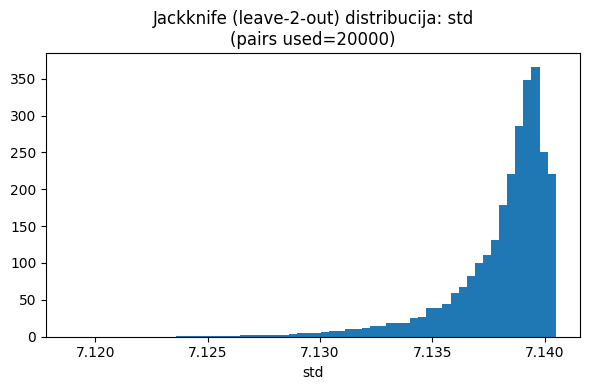

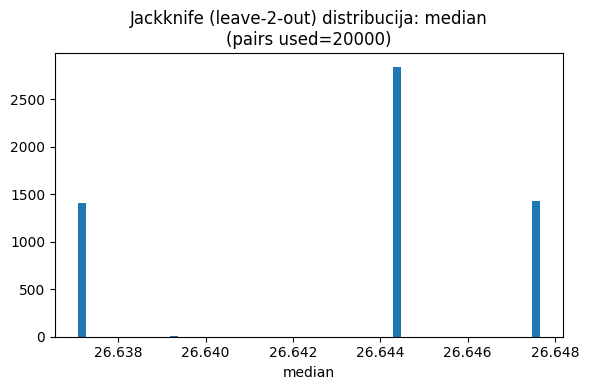

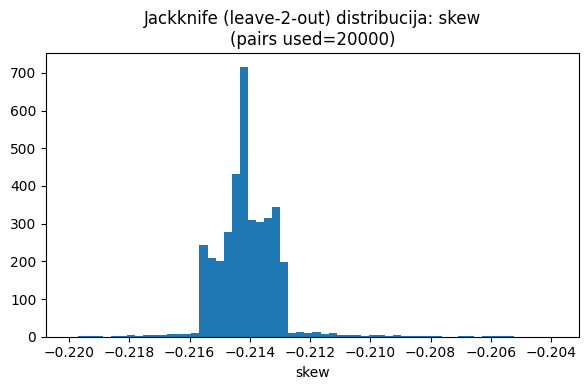


Sažetak (original):
statistic     value  boot_se  boot_ci16  boot_ci84  jack_se
      std  7.138076 0.087441   7.049314   7.224230 0.326388
   median 26.644318 0.199555  26.425217  26.864372 0.544888
 skewness -0.214088 0.041431  -0.254322  -0.171594 0.152326

Dodato 10 ekstremnih vrijednosti 1000 M⊙ -> novi n = 2960
  Statistike (s ekstremima):
   n: 2960
   mean: 29.39483779958556
   std: 56.96781244775298
   median: 26.665240647033475
   skewness: 16.722507425483748

Bootstrap (s ekstremima)...
Jackknife (s ekstremima)...


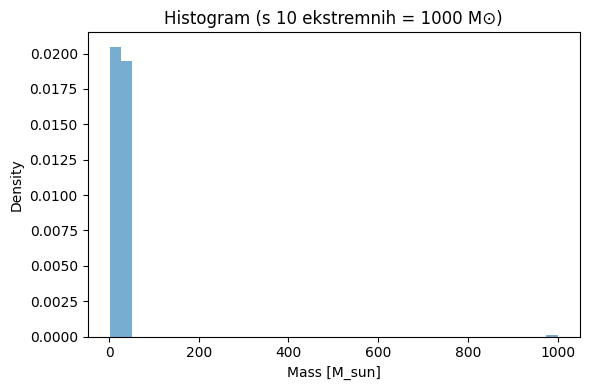


Fitting GaussianMixture N=1..10 (original data)...

GMM parametri (original) — prvo nekoliko redova:
 N  component   weight      mean    sigma
 1          0 1.000000 26.104651 7.136866
 2          0 0.476996 20.460816 4.943695
 2          1 0.523004 31.252015 4.421843
 3          0 0.670472 29.953672 4.875638
 3          1 0.238489 20.129826 1.121460
 3          2 0.091039 13.409814 4.163402
 4          0 0.259127 20.176796 1.182651
 4          1 0.377131 27.903460 3.253405
 4          2 0.096892 13.701943 4.265179
 4          3 0.266850 33.822077 3.720787
 5          0 0.248132 31.306426 2.089448
 5          1 0.273757 20.223738 1.227357


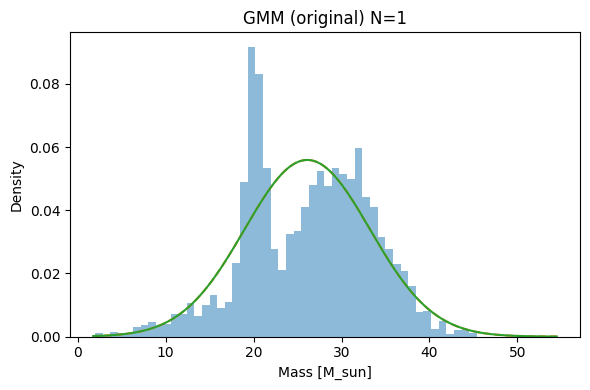

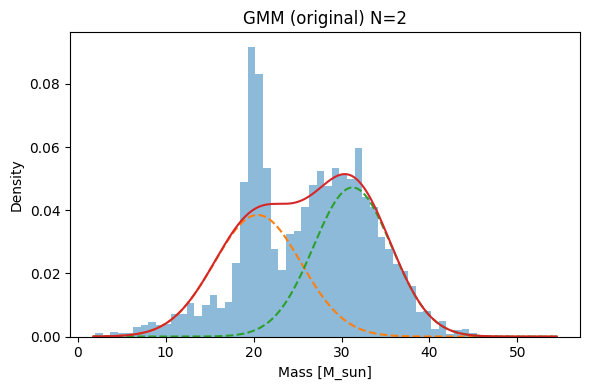

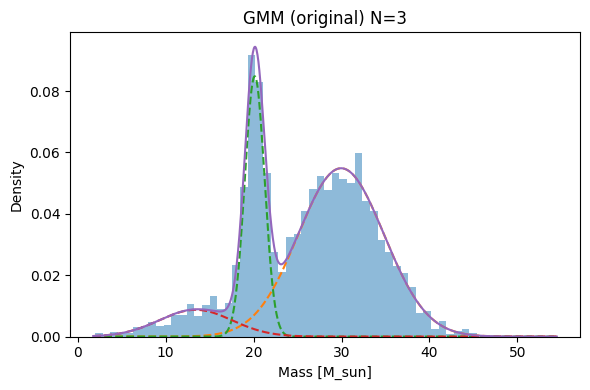

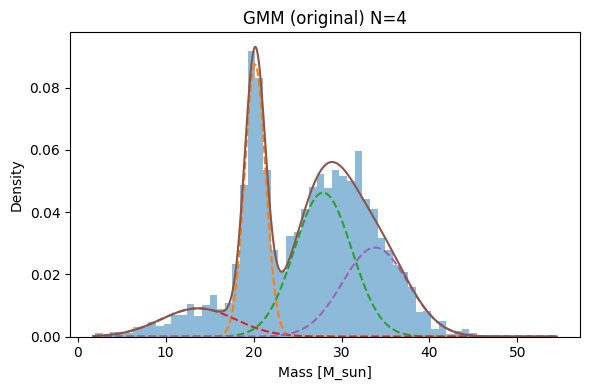

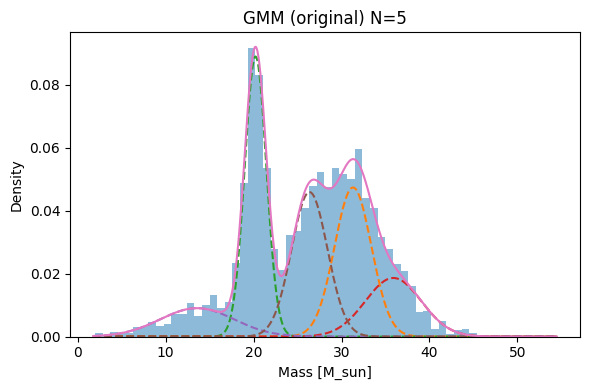

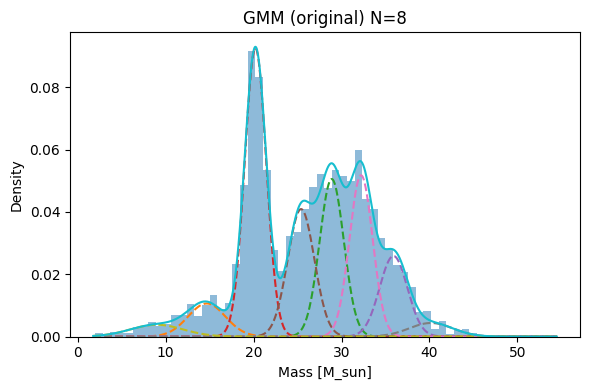

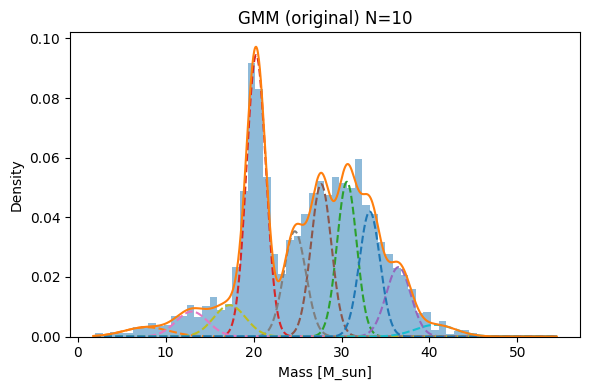


Fitting GaussianMixture N=1..10 (s ekstremima)...

GMM parametri (s ekstremima) — prvo nekoliko redova:
 N  component   weight        mean     sigma
 1          0 1.000000   29.394838 56.958189
 2          0 0.996622   26.104651  7.136866
 2          1 0.003378 1000.000000  0.001000
 3          0 0.511232   31.352967  4.371462
 3          1 0.003378 1000.000000  0.001000
 3          2 0.485389   20.576904  4.988701
 4          0 0.090200   13.371698  4.143311
 4          1 0.003378 1000.000000  0.001000
 4          2 0.667171   29.968188  4.864680
 4          3 0.239250   20.131319  1.131270
 5          0 0.438432   28.382315  3.489228
 5          1 0.003378 1000.000000  0.001000


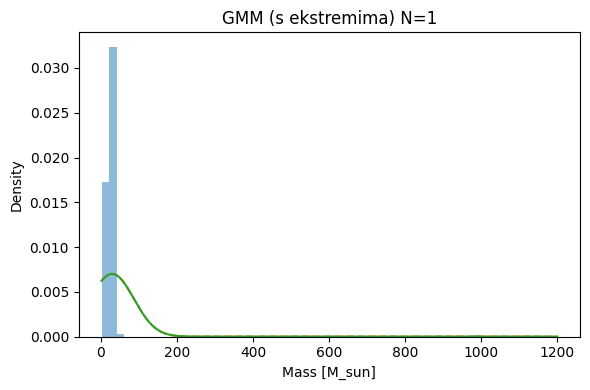

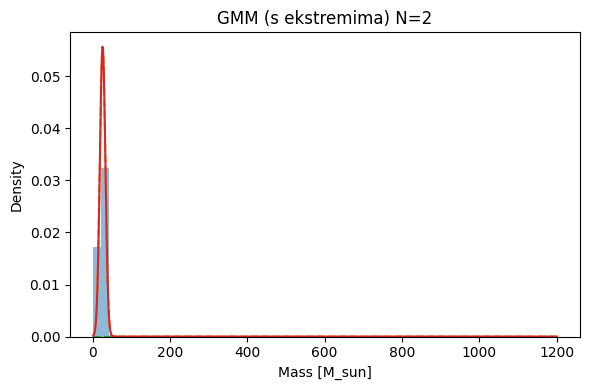

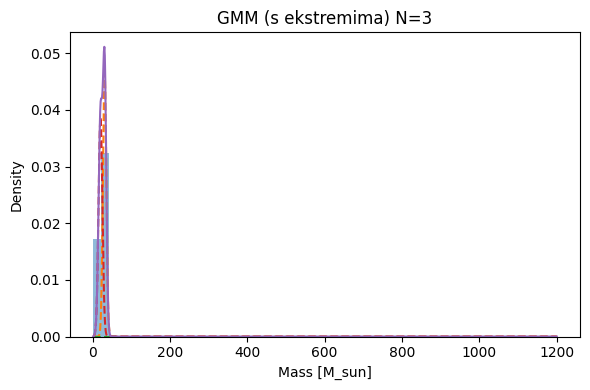

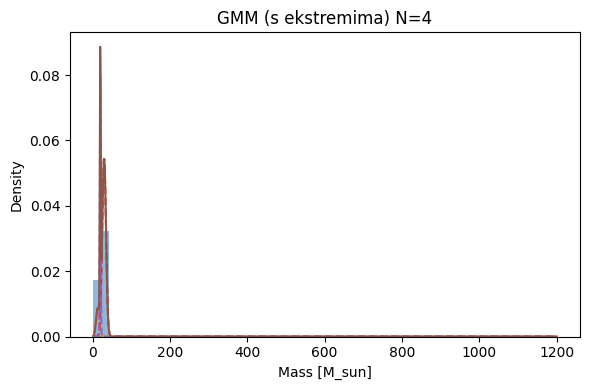

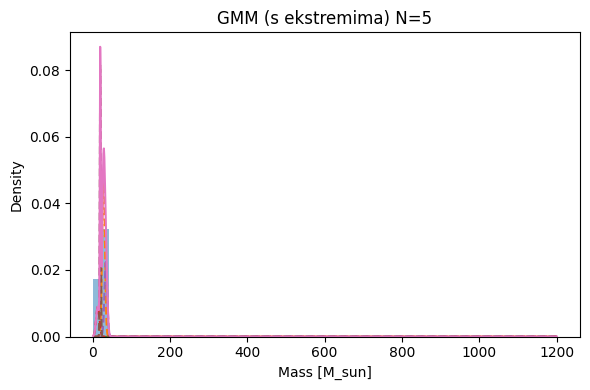

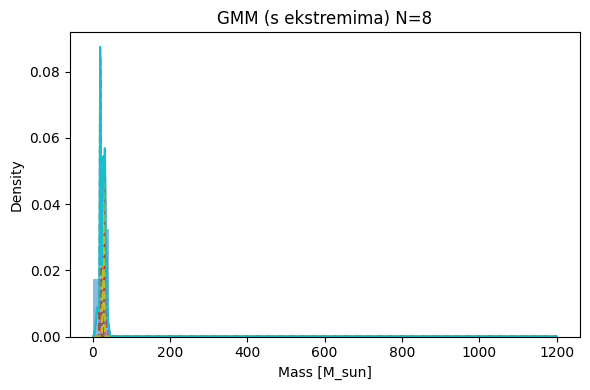

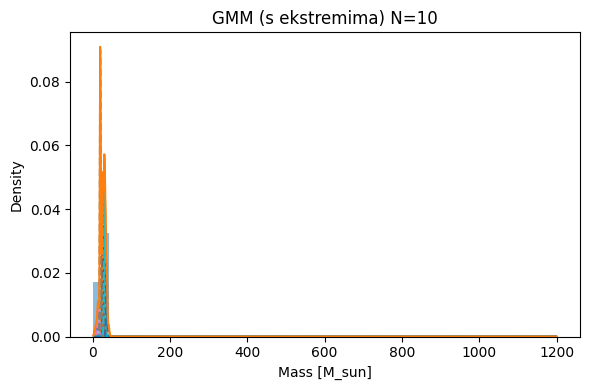


Gotovo. Sažetke i figure pogledaj iznad ili ih eksportuj iz ovog okruženja.


In [15]:
# kompletna_analiza_bhm.py
import os
import time
import math
import random
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import skew
from sklearn.mixture import GaussianMixture

# ---------------------------
# Konfiguracija
# ---------------------------
BHM_PATH = "bhm.npy"     # putanja do fajla (podesi ako treba)
N_BOOT = 10000           # broj bootstrap reuzorkovanja
JK_MAX_PAIRS = 20000     # ako je broj kombinacija > ovoga, uzimamo nasumičnih JK_MAX_PAIRS parova
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# ---------------------------
# Pomoćne funkcije
# ---------------------------
def load_bhm(path=BHM_PATH):
    if not os.path.exists(path):
        raise FileNotFoundError(f"Ne postoji '{path}' u radnom direktorijumu.")
    data = np.load(path).astype(float)
    data = data[~np.isnan(data)]
    return data

def sample_skew(x):
    # Fisher-Pearson sample skewness (bias=False)
    return skew(x, bias=False)

def compute_stats(x):
    return {
        "n": len(x),
        "mean": float(np.mean(x)),
        "std": float(np.std(x, ddof=1)),
        "median": float(np.median(x)),
        "skewness": float(sample_skew(x))
    }

def bootstrap_stats(x, nboot=N_BOOT, rng_seed=RANDOM_SEED):
    rng = np.random.default_rng(rng_seed)
    n = len(x)
    boots = np.empty((nboot, 3))   # col0: std, col1: median, col2: skew
    for i in range(nboot):
        s = rng.choice(x, size=n, replace=True)
        boots[i,0] = np.std(s, ddof=1)
        boots[i,1] = np.median(s)
        boots[i,2] = sample_skew(s)
    res = {
        "boots": boots,
        "se": boots.std(axis=0, ddof=1),
        "ci16": np.percentile(boots, 16, axis=0),
        "ci84": np.percentile(boots, 84, axis=0)
    }
    return res

def jackknife_leave_two_out(x, max_pairs_threshold=JK_MAX_PAIRS, rng_seed=RANDOM_SEED):
    n = len(x)
    total_pairs = n*(n-1)//2
    use_all = True
    if total_pairs <= max_pairs_threshold:
        pairs = list(itertools.combinations(range(n), 2))
    else:
        # sample unique pairs uniformly until dobijemo max_pairs_threshold
        use_all = False
        rng = random.Random(rng_seed)
        seen = set()
        pairs = []
        while len(pairs) < max_pairs_threshold:
            i = rng.randrange(n); j = rng.randrange(n)
            if i == j: continue
            a,b = (i,j) if i<j else (j,i)
            if (a,b) in seen: continue
            seen.add((a,b))
            pairs.append((a,b))
    m = len(pairs)
    jk_vals = np.empty((m,3))
    for k,(i,j) in enumerate(pairs):
        s = np.delete(x, (i,j))
        jk_vals[k,0] = np.std(s, ddof=1)
        jk_vals[k,1] = np.median(s)
        jk_vals[k,2] = sample_skew(s)
    jk_mean = jk_vals.mean(axis=0)
    # standard error estimate za jackknife: sqrt((m-1)/m * sum((theta_i - mean)^2))
    jk_se = np.sqrt((m-1)/m * np.sum((jk_vals - jk_mean)**2, axis=0))
    return {
        "pairs_used": m,
        "used_all_pairs": use_all,
        "jk_values": jk_vals,
        "jk_mean": jk_mean,
        "jk_se": jk_se
    }

def fit_gmms(x, n_components_range=range(1,11), random_state=RANDOM_SEED, n_init=5):
    X = x.reshape(-1,1)
    results = []
    for n in n_components_range:
        gmm = GaussianMixture(n_components=n, covariance_type="full", random_state=random_state, n_init=n_init)
        gmm.fit(X)
        weights = gmm.weights_
        means = gmm.means_.flatten()
        # covariances_ for 1D are shaped (n,1,1) -> extract [0,0]
        sigmas = np.array([np.sqrt(cov.reshape(-1)[0]) for cov in gmm.covariances_])
        results.append({
            "N": n,
            "model": gmm,
            "weights": weights,
            "means": means,
            "sigmas": sigmas
        })
    return results

def plot_hist(x, bins=50, title="Histogram", xlabel="Value"):
    plt.figure(figsize=(6,4))
    plt.hist(x, bins=bins, density=True, alpha=0.6)
    plt.title(title)
    plt.xlabel(xlabel); plt.ylabel("Density")
    plt.tight_layout()
    plt.show()

# ---------------------------
# Glavni tok
# ---------------------------
if __name__ == "__main__":
    # 1) Učitaj podatke
    data = load_bhm(BHM_PATH)
    print(f"Učitano: {len(data)} masa. Raspon: {data.min():.6g} - {data.max():.6g} (M⊙)")

    # 2) Osnovne statistike
    orig = compute_stats(data)
    print("\nOsnovne statistike (original):")
    for k,v in orig.items():
        print(f"  {k}: {v}")

    # 3) Bootstrap
    print(f"\nBootstrap: {N_BOOT} reuzorkovanja ...")
    t0 = time.time()
    boot = bootstrap_stats(data, nboot=N_BOOT)
    t_boot = time.time() - t0
    print(f"  Gotovo za {t_boot:.1f} s. SE (std, median, skew) = {boot['se']}")

    # 4) Jackknife leave-two-out
    print("\nJackknife (leave-two-out) ...")
    t0 = time.time()
    jk = jackknife_leave_two_out(data, max_pairs_threshold=JK_MAX_PAIRS)
    t_jk = time.time() - t0
    print(f"  Pairs used: {jk['pairs_used']} (used_all_pairs={jk['used_all_pairs']}). Vrijeme: {t_jk:.1f}s.")
    print(f"  Jackknife SE (std, median, skew) = {jk['jk_se']}")

    # 5) Plots: histogram + distributions
    plot_hist(data, bins=40, title="Histogram masa crnih rupa (original)", xlabel="Mass [M_sun]")

    names = ["std", "median", "skew"]
    for i,name in enumerate(names):
        plt.figure(figsize=(6,4))
        plt.hist(boot["boots"][:,i], bins=60, density=True)
        plt.title(f"Bootstrap distribucija: {name}")
        plt.xlabel(name); plt.tight_layout(); plt.show()

    for i,name in enumerate(names):
        plt.figure(figsize=(6,4))
        plt.hist(jk["jk_values"][:,i], bins=60, density=True)
        plt.title(f"Jackknife (leave-2-out) distribucija: {name}\n(pairs used={jk['pairs_used']})")
        plt.xlabel(name); plt.tight_layout(); plt.show()

    # 6) Sažetak numerički
    summary = pd.DataFrame({
        "statistic": ["std","median","skewness"],
        "value": [orig["std"], orig["median"], orig["skewness"]],
        "boot_se": boot["se"],
        "boot_ci16": boot["ci16"],
        "boot_ci84": boot["ci84"],
        "jack_se": jk["jk_se"]
    })
    print("\nSažetak (original):")
    print(summary.to_string(index=False))

    # 7) Dodaj 10 ekstremnih vrednosti i ponovi
    extreme_values = np.full(10, 1000.0)
    data_ext = np.concatenate([data, extreme_values])
    print(f"\nDodato 10 ekstremnih vrijednosti 1000 M⊙ -> novi n = {len(data_ext)}")
    ext_stats = compute_stats(data_ext)
    print("  Statistike (s ekstremima):")
    for k,v in ext_stats.items():
        print(f"   {k}: {v}")

    print("\nBootstrap (s ekstremima)...")
    boot_ext = bootstrap_stats(data_ext, nboot=N_BOOT, rng_seed=RANDOM_SEED+1)
    print("Jackknife (s ekstremima)...")
    jk_ext = jackknife_leave_two_out(data_ext, max_pairs_threshold=JK_MAX_PAIRS, rng_seed=RANDOM_SEED+1)

    plot_hist(data_ext, bins=40, title="Histogram (s 10 ekstremnih = 1000 M⊙)", xlabel="Mass [M_sun]")

    # 8) GMM fit N=1..10 (original)
    print("\nFitting GaussianMixture N=1..10 (original data)...")
    gmm_res = fit_gmms(data, n_components_range=range(1,11), random_state=RANDOM_SEED)
    # ispiši rezultate u tabeli
    rows = []
    for r in gmm_res:
        N = r["N"]
        for comp_idx, (w, mu, sig) in enumerate(zip(r["weights"], r["means"], r["sigmas"])):
            rows.append({"N":N, "component":comp_idx, "weight": float(w), "mean": float(mu), "sigma": float(sig)})
    gmm_table = pd.DataFrame(rows)
    print("\nGMM parametri (original) — prvo nekoliko redova:")
    print(gmm_table.head(12).to_string(index=False))

    # plot komponenti za odabrane N (npr. 1,2,3,4,5,8,10)
    choose = [1,2,3,4,5,8,10]
    xgrid = np.linspace(max(0, data.min()*0.9), data.max()*1.2, 1000)
    for N in choose:
        r = gmm_res[N-1]
        pdf_total = np.zeros_like(xgrid)
        plt.figure(figsize=(6,4))
        plt.hist(data, bins=50, density=True, alpha=0.5)
        for w,mu,sig in zip(r["weights"], r["means"], r["sigmas"]):
            comp_pdf = w * (1/(np.sqrt(2*np.pi)*sig)) * np.exp(-0.5*((xgrid-mu)/sig)**2)
            pdf_total += comp_pdf
            plt.plot(xgrid, comp_pdf, linestyle="--")
        plt.plot(xgrid, pdf_total, linewidth=1.5)
        plt.title(f"GMM (original) N={N}")
        plt.xlabel("Mass [M_sun]"); plt.ylabel("Density"); plt.tight_layout(); plt.show()

    # 9) GMM na podacima s ekstremima
    print("\nFitting GaussianMixture N=1..10 (s ekstremima)...")
    gmm_res_ext = fit_gmms(data_ext, n_components_range=range(1,11), random_state=RANDOM_SEED)
    rows_ext = []
    for r in gmm_res_ext:
        N = r["N"]
        for comp_idx, (w, mu, sig) in enumerate(zip(r["weights"], r["means"], r["sigmas"])):
            rows_ext.append({"N":N, "component":comp_idx, "weight": float(w), "mean": float(mu), "sigma": float(sig)})
    gmm_table_ext = pd.DataFrame(rows_ext)
    print("\nGMM parametri (s ekstremima) — prvo nekoliko redova:")
    print(gmm_table_ext.head(12).to_string(index=False))

    # plot komponenti za N izbjranih
    xgrid_ext = np.linspace(max(0, data_ext.min()*0.9), data_ext.max()*1.2, 1000)
    for N in choose:
        r = gmm_res_ext[N-1]
        pdf_total = np.zeros_like(xgrid_ext)
        plt.figure(figsize=(6,4))
        plt.hist(data_ext, bins=50, density=True, alpha=0.5)
        for w,mu,sig in zip(r["weights"], r["means"], r["sigmas"]):
            comp_pdf = w * (1/(np.sqrt(2*np.pi)*sig)) * np.exp(-0.5*((xgrid_ext-mu)/sig)**2)
            pdf_total += comp_pdf
            plt.plot(xgrid_ext, comp_pdf, linestyle="--")
        plt.plot(xgrid_ext, pdf_total, linewidth=1.5)
        plt.title(f"GMM (s ekstremima) N={N}")
        plt.xlabel("Mass [M_sun]"); plt.ylabel("Density"); plt.tight_layout(); plt.show()

    print("\nGotovo. Sažetke i figure pogledaj iznad ili ih eksportuj iz ovog okruženja.")
